In [2]:
import numpy as np
import pandas as pd
import os, time
from scipy import stats
from matplotlib import pyplot as plt

import generate_dose_response as gdr
import BMD_BMDL_estimation as bmdest
import Plot_Save as ps
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
starting_dir = os.getcwd()
print (starting_dir)

/Users/kimd999/Dropbox/script/python/srpAnalytics/analysis/paritosh_original_then_edit


In [4]:
complete_file_path = '/Users/kimd999/Dropbox/script/python/srpAnalytics/analysis/Phase_I_II.csv'

morphological_data = pd.read_csv(complete_file_path, header = 0)
display(morphological_data.head())
display(morphological_data.columns)
display(np.unique(morphological_data.well))

,chemical.id,plate.id,well,chemical_plate_well,conc,AXIS,BRAI,CFIN,CIRC,DNC_,...,PE__,PFIN,PIG_,SM24,SNOU,SOMI,SWIM,TRUN,TR__,YSE_
0,53,9289,A01,53_9289_A01,50.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,53,9289,A02,53_9289_A02,35.6,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,53,9289,A03,53_9289_A03,11.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,53,9289,A04,53_9289_A04,5.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,53,9289,A05,53_9289_A05,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Index(['chemical.id', 'plate.id', 'well', 'chemical_plate_well', 'conc',
       'AXIS', 'BRAI', 'CFIN', 'CIRC', 'DNC_', 'DP24', 'EYE_', 'JAW_', 'MO24',
       'MORT', 'NC24', 'NC__', 'OTIC', 'PE__', 'PFIN', 'PIG_', 'SM24', 'SNOU',
       'SOMI', 'SWIM', 'TRUN', 'TR__', 'YSE_'],
      dtype='object')

array(['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09',
       'A10', 'A11', 'A12', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06',
       'B07', 'B08', 'B09', 'B10', 'B11', 'B12', 'C01', 'C02', 'C03',
       'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12',
       'D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09',
       'D10', 'D11', 'D12', 'E01', 'E02', 'E03', 'E04', 'E05', 'E06',
       'E07', 'E08', 'E09', 'E10', 'E11', 'E12', 'F01', 'F02', 'F03',
       'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12',
       'G01', 'G02', 'G03', 'G04', 'G05', 'G06', 'G07', 'G08', 'G09',
       'G10', 'G11', 'G12', 'H01', 'H02', 'H03', 'H04', 'H05', 'H06',
       'H07', 'H08', 'H09', 'H10', 'H11', 'H12'], dtype=object)

In [5]:
test_data_sim = 0
if(test_data_sim == 0):
    # Add aggregate endpoints
    # 1. Any effect at 24hrs (combination of MO24, DP24 and SM24) >> 'ANY24'
    # 2. Any effect within 5 days (combination of all measurements at both time points)
    # 3. Total mortality (MO24 + MORT) >> 'TOT_MORT'
    # 4. Any effect except mortality (#2 minus MO24 and MORT) >> 'ANY_MORT'
    # Add new endpoints
    # BRAIN	OTIC	PFIN >> 'BRN_'
    # EYE	SNOUT	JAW >> 'CRAN'
    # YSE	PE >> 'EDEM'
    # TRUNK	CFIN >> 'LTRK'
    # CIRC	SWIM	SOMITE >> 'MUSC'
    # PIG_ >> 'SKIN'
    # TR_ >> 'TCHR'
    morphological_data['ANY24'] = morphological_data[['MO24','DP24','SM24','NC24']].sum(axis=1,skipna=True,min_count=1)
    morphological_data['ANY120'] = morphological_data[['MORT', 'YSE_', 'AXIS', 'EYE_', 'SNOU', 'JAW_', 'OTIC', \
                                                       'PE__', 'BRAI', 'SOMI', 'PFIN', 'CFIN', 'PIG_', 'CIRC', \
                                                       'TRUN', 'SWIM', 'NC__', 'TR__', 'DNC_', 'ANY24']].sum(axis=1,skipna=True,min_count=1)
    morphological_data['TOT_MORT'] = morphological_data[['MO24','MORT']].sum(axis=1,skipna=True,min_count=1)
    morphological_data['ANY_MORT'] = morphological_data[['DP24','SM24','NC24', 'YSE_', 'AXIS', 'EYE_', 'SNOU', 'JAW_', 'OTIC', \
                                                       'PE__', 'BRAI', 'SOMI', 'PFIN', 'CFIN', 'PIG_', 'CIRC','TRUN', 'SWIM', 'NC__', \
                                                       'TR__', 'DNC_']].sum(axis=1,skipna=True,min_count=1)

    morphological_data['BRN_'] = morphological_data[['BRAI','OTIC','PFIN']].sum(axis=1,skipna=True,min_count=1)
    morphological_data['CRAN'] = morphological_data[['EYE_', 'SNOU', 'JAW_']].sum(axis=1,skipna=True,min_count=1)
    morphological_data['EDEM'] = morphological_data[['YSE_','PE__']].sum(axis=1,skipna=True,min_count=1)
    morphological_data['LTKR'] = morphological_data[['TRUN','CFIN']].sum(axis=1,skipna=True,min_count=1)
    morphological_data['MUSC'] = morphological_data[['CIRC','SWIM','SOMI']].sum(axis=1,skipna=True,min_count=1)
    morphological_data['SKIN'] = morphological_data[['PIG_']]
    morphological_data['TCHR'] = morphological_data[['TR__']]


In [6]:
display(morphological_data.head())
morphological_data.columns

os.chdir(starting_dir)

if (os.path.isdir("report") == False):
    os.mkdir("report")
    
morphological_data_filename = os.path.join("report", 'morphological_data.csv')
morphological_data_file_out = open(morphological_data_filename, "w")
morphological_data.to_csv(morphological_data_filename, index=False)
morphological_data_file_out.close()

,chemical.id,plate.id,well,chemical_plate_well,conc,AXIS,BRAI,CFIN,CIRC,DNC_,...,ANY120,TOT_MORT,ANY_MORT,BRN_,CRAN,EDEM,LTKR,MUSC,SKIN,TCHR
0,53,9289,A01,53_9289_A01,50.0,NaN,NaN,NaN,NaN,0.0,...,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,53,9289,A02,53_9289_A02,35.6,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,53,9289,A03,53_9289_A03,11.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,53,9289,A04,53_9289_A04,5.0,1.0,0.0,0.0,0.0,0.0,...,5.0,0.0,5.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0
4,53,9289,A05,53_9289_A05,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
os.chdir(starting_dir)

if (os.path.isdir("report") == False):
    os.mkdir("report")
start_time = time.time()
# Specify end_point and chemical of interest
# *********************************************
# Perform a check of the existence of "essential" column labels
# *********************************************
#end_point = 'NC24'
#chemical_id = 3005#3005#2142#1211#1595#2770#220

#test_dose_filename = os.path.join("report", 'test_dose.csv')
#test_dose_f_out = open(test_dose_filename, "w")

#array_filename = os.path.join("report", 'array_report.csv')
#f_out = open(array_filename, "w")
#write_this = "chemical_id,end_point,len_test_dose_response\n"
#f_out.write(write_this)

qc_flag_filename = os.path.join("report", 'qc_flag.csv')
qc_flag_file_out = open(qc_flag_filename, "w")

write_this = "qc_flag\n"
qc_flag_file_out.write(write_this)

# full -> 18
#end_points = ['ANY24','ANY120','AXIS','ANY_MORT','BRN_','CRAN','DP24','EDEM','LTKR','MO24','MORT','MUSC','NC__','NC24', 'SKIN','SM24','TCHR','TOT_MORT']

#end_points = ['ANY24','ANY120','TOT_MORT','ANY_MORT','BRN_','CRAN','EDEM','LTKR','MUSC','SKIN','TCHR']
#end_points = ['AXIS','NC__','MO24','DP24','SM24','MORT']
end_points = ['EDEM']

# 336 chemicals
#for chemical_id in np.unique(morphological_data['chemical.id']):
for chemical_id in [414]:
 #   print(chemical_id)
    for end_point in end_points:
#        print(end_point)
        os.chdir(starting_dir)
        # subset original dataframe for a user-specified chemical and end_point pair
        morphological_data_end_point_chemical_id = morphological_data.loc[morphological_data['chemical.id'] == chemical_id,['chemical.id', 'conc', 'plate.id', 'well', end_point]]

        # Binarize end-point hits (Values > 1 are forced to 1)
        end_point_hits = morphological_data_end_point_chemical_id[end_point]
        end_point_hits.loc[end_point_hits > 0] = 1
        
        print (str(morphological_data_end_point_chemical_id))
        morphological_data_end_point_chemical_id.to_csv('morpho.csv', index=False)

        f_end_point = open('end_point.txt', 'w')
        f_end_point.write(str(end_point))
        f_end_point.close()
                  
        dose_response = gdr.gen_dose_response(morphological_data_end_point_chemical_id, end_point)
        print ("dose_response:" + str(dose_response))

        qc_flag = gdr.BMD_feasibility_analysis(dose_response)
        print ("qc_flag:" + str(qc_flag))
        qc_flag_file_out.write(str(qc_flag)+"\n")
       # '''
        test_dose_response = gdr.reformat_dose_response(dose_response)
#        print ("test_dose_response:" + str(test_dose_response))
#        test_dose_f_out.write(str(test_dose_response))
        
#        write_this = str(chemical_id) + "," + str(end_point) + "," + str(len(test_dose_response)) + "\n"
 #       print ("write_this:"+str(write_this))
  #      f_out.write(write_this)
    
        print (os.path.isdir(str(qc_flag)))
        if (os.path.isdir(str(qc_flag)) == False):
            os.mkdir(str(qc_flag))
        os.chdir(str(qc_flag))

        if(qc_flag in [0, 1]):
            # No BMD analysis required. Generate report and exit
            ps.save_results_poor_data_or_no_convergence(test_dose_response, qc_flag, str(chemical_id), end_point, None)
        else:
            # Fit dose response models
            model_predictions = bmdest.analyze_dose_response_data(test_dose_response)
            # Select best model
            selected_model_params = bmdest.select_model(model_predictions)
            # Check if unique model is found
            unique_model_flag = selected_model_params['no_unique_model_found_flag']
            if(unique_model_flag == 0):
                # Generate report
                print(test_dose_response.dose[-1:])
                ps.save_results_good_data_unique_model(test_dose_response, qc_flag, model_predictions, selected_model_params, str(chemical_id), end_point)
            else:
                bmd_analysis_flag = selected_model_params['model_select_flag']
                if(bmd_analysis_flag == 1):
                    ps.save_results_poor_data_or_no_convergence(test_dose_response, qc_flag, str(chemical_id), end_point, selected_model_params)
                else:
                    ps.save_results_good_data_nounique_model(test_dose_response, qc_flag, model_predictions, selected_model_params, str(chemical_id), end_point)
                  #  '''
#test_dose_f_out.close()
#f_out.close()
qc_flag_file_out.close()
end_time = time.time()
time_took = str(round((end_time-start_time), 1)) + " seconds"
print ("time_took:"+str(time_took))

       chemical.id  conc  plate.id well  EDEM
12192          414  50.0     10184  A01   0.0
12193          414  35.6     10184  A02   0.0
12194          414  11.2     10184  A03   0.0
12195          414   5.0     10184  A04   0.0
12196          414   1.0     10184  A05   0.0
...            ...   ...       ...  ...   ...
12379          414  35.6     10188  H08   0.0
12380          414  11.2     10188  H09   0.0
12381          414   5.0     10188  H10   0.0
12382          414   1.0     10188  H11   0.0
12383          414   0.0     10188  H12   0.0

[192 rows x 5 columns]
dose_response:   dose  num_affect  frac_affect  num_embryos  tot_wells
0   0.0         0.0     0.000000         30.0       32.0
1   1.0         0.0     0.000000         32.0       32.0
2   5.0         2.0     0.068966         29.0       32.0
3  11.2         3.0     0.100000         30.0       32.0
4  35.6         6.0     0.200000         30.0       32.0
5  50.0        10.0     0.333333         30.0       32.0
qc_flag:2
T

qc_flag_filename:report/qc_flag.csv


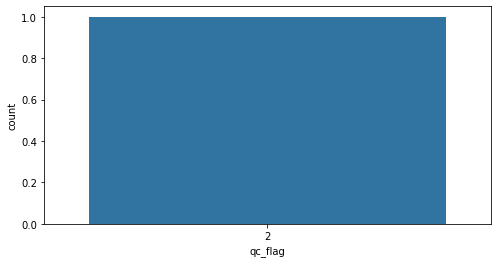

In [8]:
os.chdir(starting_dir)

print ("qc_flag_filename:"+str(qc_flag_filename))
qc_flag_data = pd.read_csv(qc_flag_filename, index_col=None)
#display(qc_flag_data.head())
ds = pd.Series({"Column": qc_flag_data["qc_flag"]})
plt.figure(figsize=(8,4))
sns.countplot(x="Column", data=ds)
plt.show()

In [9]:
os.chdir(starting_dir)

sns.set_theme(style="whitegrid")
print ("array_filename:"+str(array_filename))
array_report_data = pd.read_csv(array_filename, index_col=None)
display(array_report_data.head())
#ax = sns.barplot(x="end_point", y="len_test_dose_response", data=array_report_data)

ds = pd.Series({"Column": array_report_data["len_test_dose_response"]})
plt.figure(figsize=(8,4))
plt.xlabel("leng")
sns.countplot(x="Column", data=ds)
plt.show()
print ("done")

NameError: name 'array_filename' is not defined

In [ ]:
test_dose_response.dose

In [ ]:
test_dose_response.dose.iloc[0]+test_dose_response.dose.iloc[1]

In [ ]:
dose_response['num_affect']/dose_response['num_embryos']